In [27]:
# -----------------------------------------------
# 📦 1. Libraries and Data Load
# -----------------------------------------------
!wget https://raw.githubusercontent.com/UtkarshRaj130/Advanced_Soybean_Agricultural_Dataset_Analysis/refs/heads/main/Dataset/3_duplicates_removed.csv -O 3_duplicates_removed.csv

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("3_one_hot_encoded.csv").drop_duplicates()

# Target features
selected_features = [
    "Sugars (Su)", "Weight of 300 Seeds (W3S)",
    "Seed Yield per Unit Area (SYUA)", "Number of Seeds per Pod (NSP)",
    "Protein Percentage (PPE)", "Protein Content (PCO)", "Number of Pods (NP)"
]

df = df.dropna(subset=selected_features).reset_index(drop=True)


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [28]:
# -----------------------------------------------
# 🔁 2. KMeans Clustering (k=6 on all features)
# -----------------------------------------------
X_all = df[df.columns.difference(["Parameters", "Random "])].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

kmeans_k6 = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans_k6.fit_predict(X_scaled)

# Add labels back to original data
df_clustered = df.copy()
df_clustered["Cluster"] = cluster_labels


In [29]:
# -----------------------------------------------
# 📊 3. Production-Based Cluster Ranking
# Method 1: Total Production Feature Mean
# -----------------------------------------------
centroid_means = df_clustered.groupby("Cluster")[selected_features].mean()
centroid_means["Total"] = centroid_means.sum(axis=1)

# Rank clusters by total value
ranked = centroid_means["Total"].sort_values().reset_index()
ranked["Production_Level"] = ranked.index  # 0 (lowest) → 5 (highest)

# Map Cluster → Production Score
cluster_to_label = dict(zip(ranked["Cluster"], ranked["Production_Level"]))
df_clustered["Production_Level"] = df_clustered["Cluster"].map(cluster_to_label)

df_clustered[["Cluster", "Production_Level"]].value_counts().sort_index()


Cluster  Production_Level
0        4                   24
1        2                   26
2        0                   18
3        5                   12
4        1                   16
5        3                   12
Name: count, dtype: int64

In [30]:
# -----------------------------------------------------
# 💡 Optional: SHAP-weighted production-based ranking
# -----------------------------------------------------
shap_importances = {
    "Seed Yield per Unit Area (SYUA)": 0.22,
    "Number of Pods (NP)": 0.20,
    "Protein Content (PCO)": 0.18,
    "Weight of 300 Seeds (W3S)": 0.15,
    "Protein Percentage (PPE)": 0.10,
    "Number of Seeds per Pod (NSP)": 0.09,
    "Sugars (Su)": 0.06
}

# Compute weighted score per cluster
centroid_means["Weighted_Score"] = sum(
    centroid_means[feat] * shap_importances[feat] for feat in shap_importances
)

# Rank again using Weighted Score
ranked_weighted = centroid_means["Weighted_Score"].sort_values().reset_index()
ranked_weighted["Production_Level_Weighted"] = ranked_weighted.index
weighted_map = dict(zip(ranked_weighted["Cluster"], ranked_weighted["Production_Level_Weighted"]))
df_clustered["Production_Level_Weighted"] = df_clustered["Cluster"].map(weighted_map)


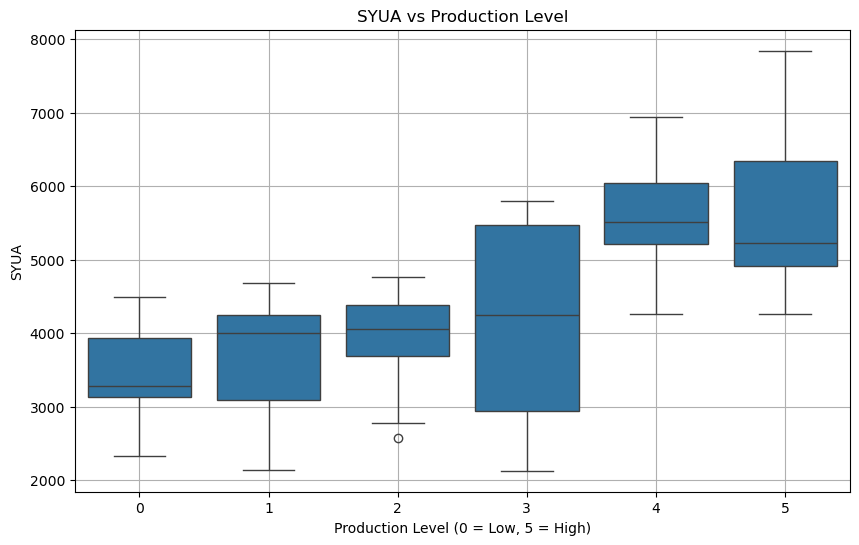

In [31]:
# -----------------------------------------------
# 📈 4. Visualize Mapping
# -----------------------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clustered, x="Production_Level", y="Seed Yield per Unit Area (SYUA)")
plt.title("SYUA vs Production Level")
plt.xlabel("Production Level (0 = Low, 5 = High)")
plt.ylabel("SYUA")
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      1.00      0.89         4
           2       0.75      1.00      0.86         6
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         6
           5       1.00      0.67      0.80         3

    accuracy                           0.89        27
   macro avg       0.92      0.89      0.89        27
weighted avg       0.91      0.89      0.89        27



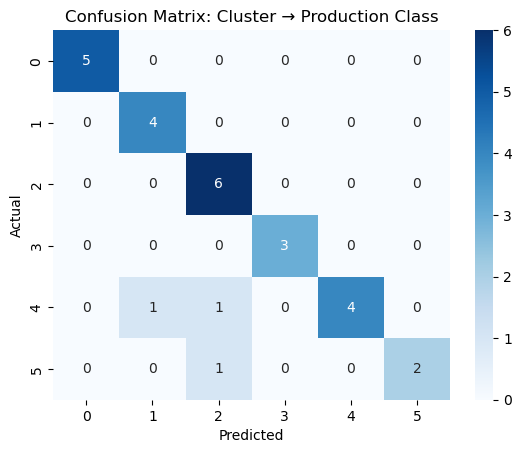

In [32]:
# -----------------------------------------------
# 🧠 5. Optional: Train Classifier to Predict Levels
# -----------------------------------------------
X = df_clustered[selected_features]
y = df_clustered["Production_Level"]  # You can also use "Production_Level_Weighted"

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Cluster → Production Class")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
